<a href="https://colab.research.google.com/github/Viroslav/MedBench/blob/main/HW_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RuMedBench
A **Ru**ssian **Med**ical language understanding **Bench**mark is the set of NLP tasks on medical textual data for the Russian language.

This repository contains code and data to reproduce the results of the paper [*RuMedBench: A Russian Medical Language Understanding Benchmark*](https://arxiv.org/abs/2201.06499).

[Video from the AIME 2022 conference](https://youtu.be/ZO7BoRzJdmE)

## Tasks Descriptions
- **RuMedTop3**\* is the task for diagnosis prediction from a raw medical text, including patient symptoms and complaints.

- **RuMedSymptomRec**\* Given an incomplete medical text, the task is to recommend the best symptom to check or verify.

- **RuMedDaNet** is the yes/no question answering task in the range of medical-related domains (pharmacology, anatomy, therapeutic medicine, etc).

- **RuMedNLI** is the natural language inference task in the clinical domain. The data is the full translated counterpart of [MedNLI](https://jgc128.github.io/mednli/) data.

- **RuMedNER** is the task of named entity recognition in drug-related user reviews. The data is from the [RuDReC](https://github.com/cimm-kzn/RuDReC) repo.

- **ECG2Pathology** is the task of assessment the quality of multilabel classification on ECG signals from the [PTB-XL dataset](https://physionet.org/content/ptb-xl/).

\*Both tasks are based on the [RuMedPrime](https://zenodo.org/record/5765873#.YbBlXT9Bzmw) dataset.

## Let's start from downloading the dataset and required libraries

In [1]:
! pip install accelerate -q
! pip install transformers -q
! pip install datasets -q
! pip install wandb -q
! pip install evaluate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 26.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... 

In [2]:
# download RuMedSymptomRec Dataset as in this task you will work only with it
! wget -P ./data/RuMedSymptomRec/ https://raw.githubusercontent.com/pavel-blinov/RuMedBench/main/data/RuMedSymptomRec/train_v1.jsonl -q # train DS
! wget -P ./data/RuMedSymptomRec/ https://raw.githubusercontent.com/pavel-blinov/RuMedBench/main/data/RuMedSymptomRec/dev_v1.jsonl   -q # val DS
! wget -P ./data/RuMedSymptomRec/ https://raw.githubusercontent.com/pavel-blinov/RuMedBench/main/data/RuMedSymptomRec/test_v1.jsonl -q # test DS

In [3]:
# imports
import os
import random
import numpy as np
import pandas as pd
from accelerate import Accelerator

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import Trainer, TrainingArguments

from datasets import Dataset
accelerator = Accelerator()
import gc
import json
import os
import shutil

# this is an interesting part, you have to set device before import torch
# os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'
import torch

# you can use wandb if you want
import wandb
wandb.init(mode="disabled")

import torch._dynamo
torch._dynamo.config.verbose=False
torch._dynamo.config.suppress_errors = True

MAX_LENGTH = 256

In [4]:
def seed_everything(seed):
    """
    seed everything for reproducibility of the code
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def hit_at_n(y_true, y_pred, n=3):
    """
    this function calculating hit_at_n metric
    """
    assert len(y_true) == len(y_pred)

    hit_count = 0
    for l, row in zip(y_true, y_pred):
        order = (np.argsort(row)[::-1])[:n]
        order = set(order)
        hit_count += int(l in order)
    return hit_count/float(len(y_true))


def model_load(model_path, weights_location, num_lables, device):
    """
    function to load model
    if you have your own pretrained model, you can use it
    """
    if weights_location == 'huggingface':
        model = accelerator.prepare(AutoModelForSequenceClassification.from_pretrained(
                                    model_path, num_labels = num_lables))
    else:
        model = accelerator.prepare(AutoModelForSequenceClassification.from_pretrained(
                                  model_path, num_labels = num_lables))

        output_model_file = os.path.join(model_path, 'pytorch_model.bin')
        loaded = torch.load(output_model_file)
        model.load_state_dict(loaded, strict=False)
        print("Model is loaded")

    return model.to(device)


def preprocess_data(data_path:str, label_column:str, parts=['train', 'dev', 'test']):
    """
    Args:
        data_path : path to data in json format
        parts : list of dataset's parts (Default: train, dev, test)

    return:
        dataset: dictionary with key - name of dataset; value - dataset
        l2i: dictionary of transitions from labels to indexes
        i2l : dictionary of transitions from indexes to labels
    """
    dataset = {}
    for part in parts:
        fname = '/{}_v1.jsonl'.format(part)
        dataframe = pd.read_json(path_or_buf=data_path+fname, lines=True)
        print('Total {} sentences in {} set '.format(len(dataframe), part))

        if part == 'train':
            set_of_labels = set(dataframe[label_column])
            print('Total {} unique labels'.format(len(set_of_labels)))

            # creating 2 dictionaries of transitions: labels_to_integer and integer_to_labels
            l2i = {code:i for i, code in enumerate(sorted(set_of_labels))}
            i2l = {l2i[l]:l for l in l2i}

        for i in range(len(dataframe)):
            dataframe.iloc[i, 2] = int(l2i[dataframe.iloc[i, 2]])
        dataframe.rename(columns={label_column:'labels'}, inplace=True)

        dataset[part] = Dataset.from_pandas(dataframe)

    return dataset, l2i, i2l

## About transformers

*We will use modern Hugging-face [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) for this task* 🤗

<br> Why do we use it ⁉
-Because it's simple and modern 😉

<br> You don't have to write training loop by your own, also inside you can change all modern things to make your training better and faster ⏰🤔

<br> ✅ Losses: adamw, adamw_fused, [lion](https://github.com/lucidrains/lion-pytorch) etc.
<br> ✅ DataTypes: fp16, [tf32](https://blogs.nvidia.com/blog/2020/05/14/tensorfloat-32-precision-format/), bf16 etc.
<br> ✅ Different models: There are a lot of different models for different task: [click](https://huggingface.co/models)
<br> ✅ The library is constantly updated and has a large community

<br> Don't forget to use [WARMUP](https://www.borealisai.com/research-blogs/tutorial-17-transformers-iii-training/) for your transformer, it can amazingly change the result ❗❗❗❗

In [5]:
 # here you can use another model or your own checkpoint of big model
model_id = 'alexyalunin/RuBioRoBERTa'

seed_list=[3558, 2375, 1906, 1042, 2960, 70, 1785, 3502, 3411, 3527]

In [9]:
# script to create a needed folders
!PathList="./out/"; \
SeedList="3558,2375,1906,1042,2960,70,1785,3502,3411,3527"; \
Field_Separator=$IFS; \
IFS=,; \
for path in $PathList; do \
    for seed in $SeedList; do \
        mkdir -p ./$path/$seed/RuMedSymptomRec/; \
    done; \
done

In [6]:
accelerator = Accelerator()
SEED = seed_list[0]
# Fixing seed
SEED = int(SEED)
seed_everything(SEED)
print("Working with SEED - {}".format(SEED))

# device == cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.environ["TOKENIZERS_PARALLELISM"] = "True"
print("Training on {}".format(device))

# check for task_name existance, you can also use this code to solve RuMedTop3 task
task_name = 'RuMedSymptomRec'
if task_name=='RuMedTop3' or task_name=='RuMedSymptomRec':
    pass
    print("Working on {} task".format(task_name))
else:
    raise ValueError('unknown task')

# out folder path
out_dir = './out/'

# load data
data_path = os.path.join('data', task_name)

# initialize tokenizer through using accelerator
tokenizer = accelerator.prepare(AutoTokenizer.from_pretrained(
    model_id,
    do_lower_case=True,
    max_length=256,
    use_fast=True))

dataset, l2i, i2l = preprocess_data(data_path=data_path, label_column="code")

def preprocess_function(data):
    """
    just a simple preprocess function
    """
    inputs = tokenizer(data['symptoms'], add_special_tokens=True, max_length=MAX_LENGTH, padding="max_length", truncation=True)
    return {'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask'], 'labels': data['labels']}

batched = True
dataset_train= dataset['train'].map(preprocess_function, batched=batched)
dataset_val = dataset['dev'].map(preprocess_function, batched=batched)
dataset_test = dataset['test'].map(preprocess_function, batched=batched)

model = model_load(model_path=model_id,
                    weights_location='huggingface',
                    num_lables = len(l2i), device=device)


# as we use trainer we have to redefine compute metrics function
def compute_metrics(eval_pred):
    """
    here are our main metrics computing function
    """
    predictions, references = eval_pred
    val_accuracy = hit_at_n(y_true=references, y_pred=predictions, n=1) * 100
    val_hit_at3 = hit_at_n(y_true=references, y_pred=predictions, n=3) * 100
    val_weighted_acc = (val_accuracy+val_hit_at3) / 2
    return {
        'val_accuracy': val_accuracy,
        'val_hit_at3': val_hit_at3,
        'val_weighted_ac': val_weighted_acc}


training_args = TrainingArguments(
    # load params
    output_dir='./results',
    overwrite_output_dir=True,

    # batch, learning_rate, epochs
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=3e-5,
    num_train_epochs=10,
    # no_cuda=False,
    max_grad_norm=1.0,
    #use_ipex=True,  # to use Intel extension if train on cp

    # determinism
    seed=SEED,
    data_seed=SEED,

    # PyTorch 2.0
    #bf16=True,
    fp16=True,
    # tf32=True,
    torch_compile=False,
    warmup_steps=1000,
    optim='adamw_torch_fused',
    weight_decay=0.01,

    # logging/eval
    logging_dir='./logs',
    logging_strategy="epoch",
    evaluation_strategy = "epoch",

    # metrics
    load_best_model_at_end=True,
    skip_memory_metrics=True,
    metric_for_best_model='val_weighted_ac',
    save_strategy='epoch',

    # push params
    #run_name="my_single",
    report_to = None,
    push_to_hub=False
    )


trainer = Trainer(
        model=model,
        args=training_args,
        tokenizer= tokenizer,
        train_dataset=dataset_train,
        eval_dataset=dataset_val,
        compute_metrics=compute_metrics)

trainer.train()

predictions, label_ids, metrics = trainer.predict(dataset_test)
print("Metrics on test:", metrics)

Working with SEED - 3558
Training on cuda
Working on RuMedSymptomRec task


Total 2470 sentences in train set 
Total 141 unique labels
Total 415 sentences in dev set 
Total 415 sentences in test set 


Map:   0%|          | 0/2470 [00:00<?, ? examples/s]

Map:   0%|          | 0/415 [00:00<?, ? examples/s]

Map:   0%|          | 0/415 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at alexyalunin/RuBioRoBERTa and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Val Accuracy,Val Hit At3,Val Weighted Ac
1,4.975800,4.909652,1.686747,4.096386,2.891566
2,4.723600,4.454033,8.433735,18.554217,13.493976
3,4.099200,3.836432,13.734940,33.734940,23.734940
4,3.428400,3.397009,23.132530,42.409639,32.771084
5,2.712600,3.022272,33.493976,49.638554,41.566265
6,2.084800,2.859951,36.626506,52.530120,44.578313
7,1.542400,2.693261,41.445783,57.108434,49.277108
8,1.109000,2.657400,42.650602,57.349398,50.000000
9,0.806400,2.594460,43.132530,58.072289,50.602410
10,0.633300,2.596820,44.096386,59.277108,51.686747


Metrics on test: {'test_loss': 2.3123278617858887, 'test_val_accuracy': 48.674698795180724, 'test_val_hit_at3': 63.85542168674698, 'test_val_weighted_ac': 56.26506024096385, 'test_runtime': 6.8482, 'test_samples_per_second': 60.6, 'test_steps_per_second': 7.593}


FileNotFoundError: ignored

In [10]:

out_dir_seed = out_dir+f'/{SEED}/{task_name}'
try:
    os.mkdir(out_dir_seed)
except:
    pass

# converting list of predictions in integers to list of predictions in labels
preds_in_labels = [(list(np.argsort(pred)[::-1])[:3]) for pred in predictions]
for i in range(len(preds_in_labels)):
    preds_in_labels[i] = [i2l[j] for j in preds_in_labels[i]]

# converting list of labels in integers to list of labels in labels
labels = [i2l[label] for label in dataset_test['labels']]

# dump history to json
with open(f'{out_dir_seed}/history.json', 'a') as fw:
    json.dump(trainer.state.log_history, fw, ensure_ascii=False)
    fw.write('\n')
    print("History is dumped into .json file")

# dump metrics to json
with open(f'{out_dir_seed}/metrics.json', 'a') as fw:
    json.dump(metrics, fw, ensure_ascii=False)
    fw.write('\n')
    print("Metrics are dumped into .json file")

# dump predictions on test to .JSON
with open(f'{out_dir_seed}/{task_name}.jsonl', 'w') as fw:
    for i in range(len(dataset_test)):
        data = {'idx':dataset_test['idx'][i], 'code':labels[i], 'prediction':preds_in_labels[i]}
        json.dump(data, fw, ensure_ascii=False)
        fw.write('\n')
print("Predictions are dumped into .json file")

# after all we clean results
shutil.rmtree('./results')
gc.collect()
torch.cuda.empty_cache()

History is dumped into .json file
Metrics are dumped into .json file
Predictions are dumped into .json file


## Evaluating

In [14]:
out_dir = './out/'

out_dir.split('/')[-2]
list_of_dirs = os.listdir(out_dir)
list_of_dirs

['3502', '2375', '2960', '1785', '70', '1906', '3558', '3411', '3527', '1042']

In [29]:
# -*- coding: utf-8 -*-
import os
import json
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def hit_at_3(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    hit_count = 0
    for l, row in zip(y_true, y_pred):
        hit_count += l in row
    return hit_count/float(len(y_true))


out_dir = './out/'
if not os.path.exists(out_dir):
    raise ValueError('{} directory does not exist'.format(out_dir))

list_of_dirs = os.listdir(out_dir)


for directory in list_of_dirs:
    out_dir = './out/'
    out_dir = out_dir + directory + '/'
    print("\n")
    metrics, label_id = {}, 'code'

    # RuMedTop3, RuMedSymptomRec ---------------------------------------------#
    for task in ['RuMedSymptomRec']:
        fname = '{}/{}.jsonl'.format(task, task)
        if os.path.isfile(out_dir+fname):
            fname = os.path.join(out_dir, fname)
            with open(fname) as f:
                result = [json.loads(line) for line in list(f)]

            gt = [d[label_id] for d in result]
            top1 = [d['prediction'][0] for d in result]
            top3 = [set(d['prediction']) for d in result]

            metrics[(task, 'acc')] = accuracy_score(gt, top1)*100
            metrics[(task, 'hit3')] = hit_at_3(gt, top3)*100
        else:
            print ('skip task {}'.format(task))

    rec_acc, rec_hit = metrics.get( ('RuMedSymptomRec', 'acc'), 0 ), metrics.get( ('RuMedSymptomRec', 'hit3'), 0 )

    seed = int(out_dir.split('/')[-2])

    print_line = '| Seed\t| RuMedSymptomRec|'
    result_line = '| {}\t| {:.2f} / {:.2f}\t|'.format(
        seed,
        rec_acc, rec_hit
        )
    res = {
            'Seed': seed,
            'RuMedSymptomRec_acc': rec_acc,
            'RuMedSymptomRec_hit3': rec_hit,
            'RuMedSymptomRec_w': (rec_acc+rec_hit)/2,
            }
    print(print_line, '\n', result_line)
    with open(f'{os.path.join(out_dir)}/results.jsonl', 'w') as fw:
        json.dump(res, fw, ensure_ascii=False)
        print('results are dumped into .jsonl')
    print("*"*100)



skip task RuMedSymptomRec
| Seed	| RuMedSymptomRec| 
 | 3502	| 0.00 / 0.00	|
results are dumped into .jsonl
****************************************************************************************************


skip task RuMedSymptomRec
| Seed	| RuMedSymptomRec| 
 | 2375	| 0.00 / 0.00	|
results are dumped into .jsonl
****************************************************************************************************


skip task RuMedSymptomRec
| Seed	| RuMedSymptomRec| 
 | 2960	| 0.00 / 0.00	|
results are dumped into .jsonl
****************************************************************************************************


skip task RuMedSymptomRec
| Seed	| RuMedSymptomRec| 
 | 1785	| 0.00 / 0.00	|
results are dumped into .jsonl
****************************************************************************************************


skip task RuMedSymptomRec
| Seed	| RuMedSymptomRec| 
 | 70	| 0.00 / 0.00	|
results are dumped into .jsonl
************************************************

In [39]:
def get_total(path):

    seed_list=[2375, 1906, 1042, 2960, 70]
    df1 = pd.read_json(f'{path}/3558/results.jsonl', orient='index').T
    for seed in seed_list:

        df = pd.read_json(f'{path}/{seed}/results.jsonl', orient='index').T
        df1 = pd.concat([df1, df])

    df1['Seed'] = df1['Seed'].astype(int)
    df1 = df1.reset_index().drop(columns=['index'])

    total = df1[['Seed', 'RuMedSymptomRec_w']]
    total = total.rename(columns={
                      'RuMedSymptomRec_w':'RuMedSymptomRec',
                      })
    return total, df1

In [40]:
total_bert, full_bert = get_total('./out')

In [52]:
full_bert

,Seed,RuMedSymptomRec_acc,RuMedSymptomRec_hit3,RuMedSymptomRec_w
0,3558,48.674699,63.855422,56.265060
1,2375,47.823123,60.382138,54.102631
2,1906,49.149213,64.532543,56.840878
3,1042,48.031293,62.352435,55.191864
4,70,47.213214,63.214124,55.213669


# Now it's time to plot the results and analize

<Axes: >

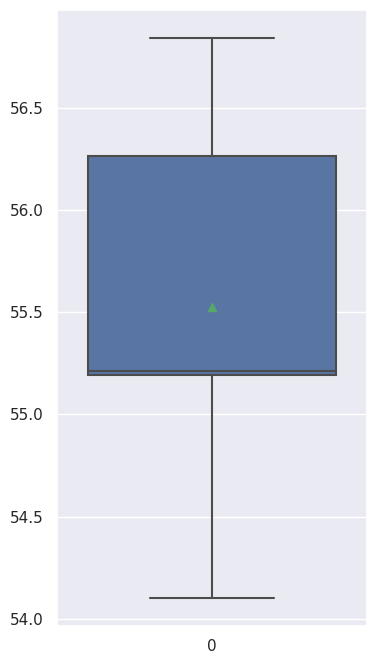

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set(rc={'figure.figsize':(4, 8)})
sns.boxplot(full_bert['RuMedSymptomRec_w'], showmeans=True)

## Your task is to train at least on 4-5 seeds and plot boxplot. Also describe your results, you can try to use lion_32bit or lion_16bit as optimizer or change any hypeparameter you want. Your goal is to get 4-5 seed's median $\frac{acc+hit@3}{2} \geq 55$. Good Luck!